In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

# do something to prove it works
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)

[791, 493, 471, 215, 623]

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

print('Modules are imported.')

Modules are imported.


In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("Covid19Analysis").getOrCreate()

covid_data = spark.read.csv('covid-19.csv', header=True, inferSchema=True)

# Perform necessary data transformations
covid_data = covid_data.withColumn("date", F.to_date("date", "yyyy-MM-dd"))

In [4]:
# Filter data for selected countries
countries = ['china', 'italy', 'us', 'spain']
selected_countries_data = covid_data.filter(covid_data['country'].isin(countries))
selected_countries_data = selected_countries_data.withColumn("date", F.to_date("date"))

# Filter data for June 2021
selected_month_data = selected_countries_data.filter((F.month("date") == 6) & (F.year("date") == 2021))

# Convert 'date' to numerical values for derivative calculation
selected_month_data = selected_month_data.withColumn("date_numeric", F.unix_timestamp("date"))

# Calculate the first derivative of confirmed cases for each country
windowSpec = Window.partitionBy("country").orderBy("date")

selected_month_data = selected_month_data.withColumn("daily_confirmed", F.col("confirmed") - F.lag("confirmed").over(windowSpec))

# Filter out the first day for each country since daily changes will be null
selected_month_data = selected_month_data.filter(~F.isnull("daily_confirmed"))

# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = selected_month_data.toPandas()

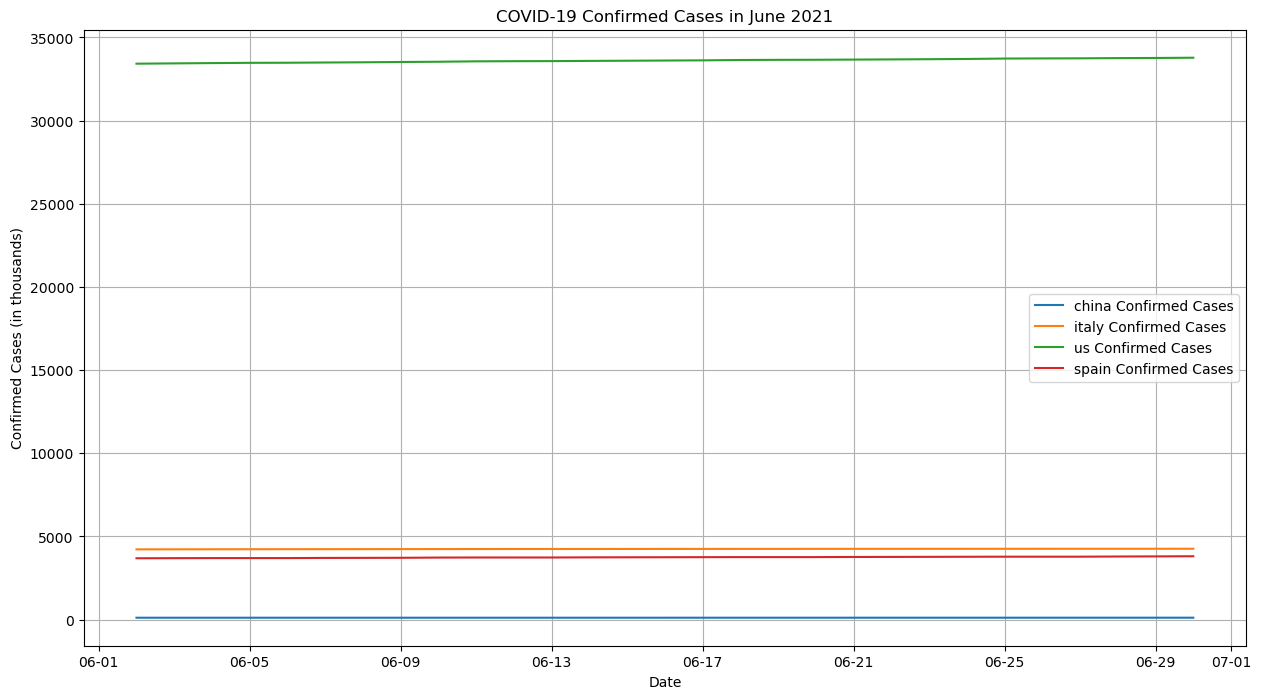

In [5]:
# Visualize confirmed cases
plt.figure(figsize=(15, 8))
for country in countries:
    country_data = pandas_df[pandas_df['country'] == country]
    plt.plot(country_data['date'], country_data['confirmed'], label=f'{country} Confirmed Cases')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('COVID-19 Confirmed Cases in June 2021')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases (in thousands)')
plt.legend()
plt.grid(True)
plt.show()

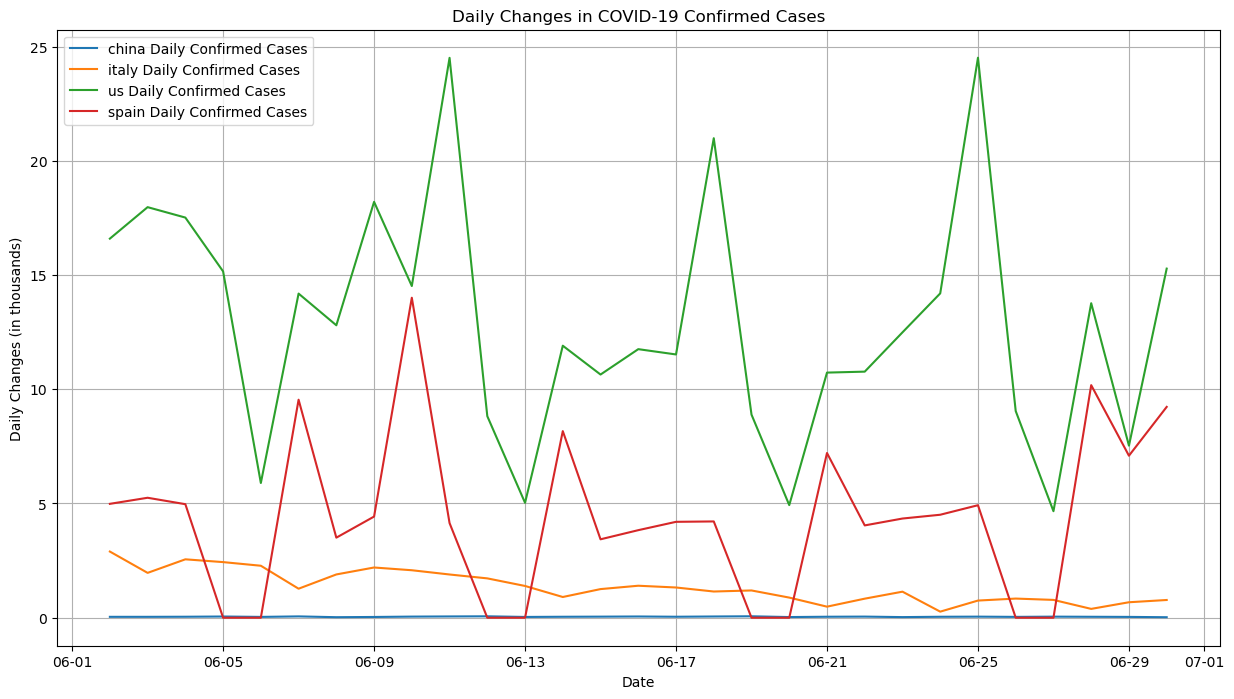

In [6]:
# Visualize daily changes
plt.figure(figsize=(15, 8))
for country in countries:
    country_data = pandas_df[pandas_df['country'] == country]
    plt.plot(country_data['date'], country_data['daily_confirmed'], label=f'{country} Daily Confirmed Cases')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('Daily Changes in COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Daily Changes (in thousands)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Stop the Spark session
spark.stop()